(battery_reserves)=
# Reserves on batteries

This example illustrates how [batteries](battery) can be used together with the [reserve](reserves) functionality in SHOP.

The model setup for this example is available in the following format:
- pyshop
    - [](battery.py)

In [1]:
#Necessary imports used in all examples
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from pyshop import ShopSession

#Functions used in this example for building a basic SHOP model and running it
from battery import build_model, run_model


## Create SHOP session and import basic model

Our example model consists of two [reservoirs](reservoir) and two [plants](plant) with one [generator](generator) each.

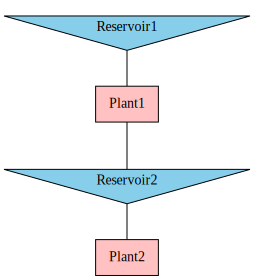

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a basic SHOP model
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

## Add reserve group and reserve obligations
We add a [reserve group](reserve_group), and connect both generators to it. We also specify the different types of reserve obligations.

In [3]:
#Add reserve group
RG = shop.model.reserve_group.add_object('RG')

#Add reserve obligations
RG.fcr_n_up_obligation.set(5)
RG.fcr_n_down_obligation.set(2)
RG.frr_up_obligation.set(2)
RG.frr_down_obligation.set(1)

#Connect the generators to the reserve group
for i, gen in enumerate(shop.model.generator):
    gen.connect_to(RG)

## Run SHOP
We run the model without any battery for later comparison.

In [4]:
#Run SHOP
run_model(shop)

## Reserve capacity without battery
The plot below shows the production of each generator with the added reserve obligations, compared to the [market](market) price. We see that the generator at plant 1 remains turned on during periods when the price is low. This is due to the down delivery obligations and the fcr-up obligation.

In [5]:
colors=["skyblue", "steelblue"]

#Get market price data
price=shop.model.market.Day_ahead.sale_price.get()

#Plot production and price
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(barmode="stack", title="Price and production")
fig.add_trace(go.Scatter(x=price.index, y=price.values, name="Price", marker=dict(color="black")), secondary_y=True)
fig.update_yaxes(title_text="Price", secondary_y=True)
fig.update_yaxes(title_text="Production", secondary_y=False)
fig.update_xaxes(tickformat="%H:%M")
for i, gen in enumerate(shop.model.generator):
    data=gen.production.get()
    fig.add_trace(go.Bar(x=data.index, y=data.values, name=f'Production {gen.get_name()}', marker=dict(color=colors[i])), secondary_y=False)
fig.show()

The plot below shows the delivery to the different reserve markets from our two generators.

In [6]:
#Plot reserve market deliveries
fig = make_subplots(rows=2, cols=2, start_cell="top-left", subplot_titles=("FRR up delivery", "FRR down delivery", "FCR-n up delivery", "FCR-n down delivery"))
fig.update_layout(barmode="stack")
fig.update_yaxes(title_text="Production", row=1, col=1)
fig.update_yaxes(title_text="Production", row=2, col=1)
fig.update_xaxes(tickformat="%H:%M")
for i, gen in enumerate(shop.model.generator):
    fig.add_trace(go.Bar(x=gen.frr_up_delivery.get().index, y=gen.frr_up_delivery.get().values, name=gen.get_name(), marker=dict(color=colors[i])), row=1, col=1)
    fig.add_trace(go.Bar(x=gen.frr_down_delivery.get().index, y=gen.frr_down_delivery.get().values, showlegend=False, marker=dict(color=colors[i])), row=1, col=2)
    fig.add_trace(go.Bar(x=gen.fcr_n_up_delivery.get().index, y=gen.fcr_n_up_delivery.get().values, showlegend=False, marker=dict(color=colors[i])), row=2, col=1)
    fig.add_trace(go.Bar(x=gen.fcr_n_down_delivery.get().index, y=gen.fcr_n_down_delivery.get().values, showlegend=False, marker=dict(color=colors[i])), row=2, col=2)
fig.show()

## Add battery and rerun model
We will now add a [battery](battery) to our model and connect it to the reserve group. We then rerun shop.

In [7]:
#Create a standard ShopSession
shop2=ShopSession()
#Build a basic SHOP model
build_model(shop2)

#Add reserve group 
RG = shop2.model.reserve_group.add_object('RG')

#Add reserve obligations
RG.fcr_n_up_obligation.set(5)
RG.fcr_n_down_obligation.set(2)
RG.frr_up_obligation.set(2)
RG.frr_down_obligation.set(1)

#Connect the generators to the reserve group
for i, gen in enumerate(shop2.model.generator):
    gen.connect_to(RG)

#Add battery
battery = shop2.model.battery.add_object('Battery')
battery.charge_efficiency.set(0.95)
battery.discharge_efficiency.set(0.95)
battery.max_charge_power.set(6.0)
battery.max_discharge_power.set(6.0)
battery.max_energy.set(12.0)
battery.initial_energy.set(0.5)
battery.connect_to(shop2.model.busbar.Busbar)
shop2.model.battery.Battery.connect_to(RG)

#Run SHOP
run_model(shop2)

## Reserve capacity with battery
The first plot below shows the [generator production](generator:production) and the [battery net discharge](battery:net_power_discharge) with the added reserve obligations. In contrast to the above example, we see that both generators can now be turned off during low price periods.

In [8]:
#Get battery net discharge
battery_discharge=shop2.model.battery.Battery.power_discharge.get()
battery_charge=shop2.model.battery.Battery.power_charge.get()
#Get price data
price=shop2.model.market.Day_ahead.sale_price.get()

#Plot price and production
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(barmode="relative", title="Price and production")
fig.update_yaxes(title_text="Price", secondary_y=True)
fig.update_yaxes(title_text="Production", secondary_y=False)
fig.update_xaxes(tickformat="%H:%M")
fig.add_trace(go.Scatter(x=price.index, y=price.values, name="Price", marker=dict(color="black")), secondary_y=True)
fig.add_trace(go.Bar(x=battery_discharge.index, y=battery_discharge.values, name=f'Battery discharge', marker=dict(color="indianred")), secondary_y=False)
fig.add_trace(go.Bar(x=battery_charge.index, y=-battery_charge.values, name=f'Battery charge', marker=dict(color="darkseagreen")), secondary_y=False)
for i, gen in enumerate(shop2.model.generator):
    fig.add_trace(go.Bar(x=gen.production.get().index, y=gen.production.get().values, name=f'Production {gen.get_name()}', marker=dict(color=colors[i])), secondary_y=False)
fig.show()



From the reserve market delivery plots we see that the battery now delivers most of the reserves.

In [9]:
#Plot reserve market deliveries
fig = make_subplots(rows=2, cols=2, start_cell="top-left", subplot_titles=("FRR up delivery", "FRR down delivery", "FCR-n up delivery", "FCR-n down delivery"))
fig.update_layout(barmode="stack")
fig.update_yaxes(title_text="Production", row=1, col=1)
fig.update_yaxes(title_text="Production", row=2, col=1)
fig.update_xaxes(tickformat="%H:%M")
fig.add_trace(go.Bar(x=shop2.model.battery.Battery.frr_up_delivery.get().index, y=shop2.model.battery.Battery.frr_up_delivery.get().values, name="Battery", marker=dict(color="indianred")), row=1, col=1)
fig.add_trace(go.Bar(x=shop2.model.battery.Battery.frr_down_delivery.get().index, y=shop2.model.battery.Battery.frr_down_delivery.get().values, showlegend=False, marker=dict(color="indianred")), row=1, col=2)
fig.add_trace(go.Bar(x=shop2.model.battery.Battery.fcr_n_up_delivery.get().index, y=shop2.model.battery.Battery.fcr_n_up_delivery.get().values, showlegend=False, marker=dict(color="indianred")), row=2, col=1)
fig.add_trace(go.Bar(x=shop2.model.battery.Battery.fcr_n_down_delivery.get().index, y=shop2.model.battery.Battery.fcr_n_down_delivery.get().values, showlegend=False, marker=dict(color="indianred")), row=2, col=2)
for i, gen in enumerate(shop2.model.generator):
    fig.add_trace(go.Bar(x=gen.frr_up_delivery.get().index, y=gen.frr_up_delivery.get().values, name=gen.get_name(), marker=dict(color=colors[i])), row=1, col=1)
    fig.add_trace(go.Bar(x=gen.frr_down_delivery.get().index, y=gen.frr_down_delivery.get().values, showlegend=False, marker=dict(color=colors[i])), row=1, col=2)
    fig.add_trace(go.Bar(x=gen.fcr_n_up_delivery.get().index, y=gen.fcr_n_up_delivery.get().values, showlegend=False, marker=dict(color=colors[i])), row=2, col=1)
    fig.add_trace(go.Bar(x=gen.fcr_n_down_delivery.get().index, y=gen.fcr_n_down_delivery.get().values, showlegend=False, marker=dict(color=colors[i])), row=2, col=2)
fig.show()